In [1]:
from rclone import download_folder_from_onedrive
import os
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import yaml

import cv2
from PIL import Image, ImageDraw, ImageFont

from ultralytics import YOLO
import torch

In [ ]:
download_folder_from_onedrive('datasets', 'datasets')

rclone command: rclone copy onedrive_bocconi:AI-project/datasets datasets -P
SUCCESS: Folder downloaded successfully.


True

In [4]:
os.listdir('datasets')

['SumTablets_Photos_train_0_10000.csv',
 'SumTablets_validation.csv',
 'SumTablets_Photos_test.csv',
 'SumTablets_Photos_validation.csv',
 'SumTablets_test.csv',
 'SumTablets_English_test.csv',
 'SumTablets_English_validation.csv',
 'SumTablets_English_train.csv',
 'SumTablets_English-augmented.csv']

In [ ]:
data = pd.read_csv('datasets/SumTablets_Photos_test.csv')

# replace all words in <> with empty string
transcriptions = data.loc[:, 'glyphs'].replace(r'<.*?>', '', regex=True)

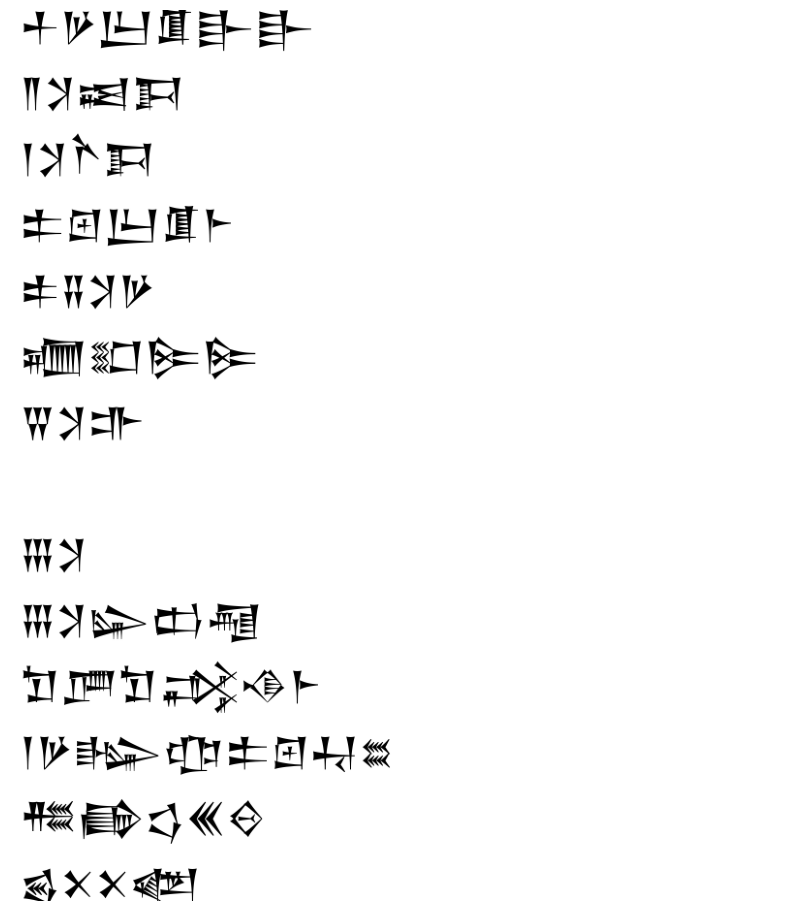

In [ ]:
# generate image from transcription
def generate_image_from_transcription(transcription):

    transcription = transcription.replace('...', '')
    
    # Adapt height and width based on the transcription
    width = max(800, len(transcription) * 10)
    height = len(transcription.split('\n')) * 60 + 20  # 20 pixels per line

    img = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(img)

    # Load a font
    try:
        font = ImageFont.truetype("fonts/NotoSansCuneiform-Regular.ttf", 40)
    except IOError:
        font = ImageFont.load_default()

    # Draw the transcription text on the image
    d.text((10, -100), transcription, fill=(0, 0, 0), font=font)

    return img

img = generate_image_from_transcription(transcriptions.iloc[0])
# Show the image with plt
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(np.array(img))
plt.axis('off')
plt.show()

# save the image
os.makedirs('tablet_example', exist_ok=True)
img.save(f'tablet_example/{data.iloc[0,0]}.png')

In [2]:
# Load the trained YOLO model
model = YOLO('yolo_classifier/best_v2.pt')


0: 640x576 1 cuneiform_U12030, 1 cuneiform_U12033, 2 cuneiform_U120EFs, 1 cuneiform_U120FC, 1 cuneiform_U12117, 1 cuneiform_U12129, 1 cuneiform_U12154, 1 cuneiform_U121AC, 1 cuneiform_U121AF, 1 cuneiform_U12212, 1 cuneiform_U1222B, 1 cuneiform_U1222C, 1 cuneiform_U1222F, 1 cuneiform_U12241, 1 cuneiform_U12292, 1 cuneiform_U122B4, 1 cuneiform_U122D9, 2 cuneiform_U12302s, 1 cuneiform_U12356, 1 cuneiform_U1235D, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


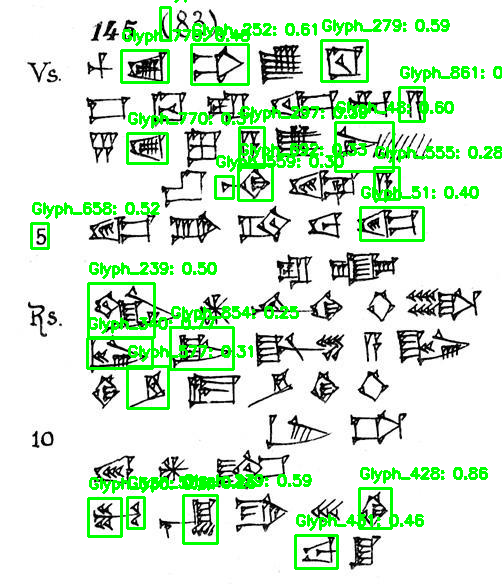

In [7]:
# ─── PARAMETERS ────────────────────────────────────────────────────────────────
TEST_IMG_PATH = "image (3).jpg"  # Path to a single test image

# ─── TEST PREDICTIONS ON SINGLE IMAGE ─────────────────────────────────────────
def test_model_on_image(img_path):
    # Load the test image
    img = Image.open(img_path)
    
    # Perform segmentation prediction
    results = model(img)  # Use the pre-trained model
    
    # The results are now a list of detections
    result = results[0]  # The first (and only) result
    
    # Get predictions (boxes, scores, etc.)
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (xyxy format)
    confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = result.boxes.cls.cpu().numpy()  # Class IDs
    
    # Convert image for visualization (RGB -> BGR for OpenCV)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Draw predictions on the image
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
        
        # Draw label and confidence
        label = f"Glyph_{int(class_id)}: {conf:.2f}"
        cv2.putText(img_cv2, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert back to RGB for displaying with PIL
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    
    # Display in Jupyter Notebook
    display(img_pil)

    # return the list of predictions
    return list(zip(boxes, confidences, class_ids))

# Test the model on the single image
res = test_model_on_image(TEST_IMG_PATH)

In [9]:
# check which glyph the class id corresponds to in the yuml file
with open('yolo_dataset/glyphs-seg.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

chars = []
for i in range(len(res)):
    box, conf, class_id = res[i]
    a = data_yaml['names'][int(class_id)].replace('cuneiform_', '')
    
    print(class_id)
    print(chr(int(a[1:], 16)))
    
    chars.append(chr(int(a[1:], 16)))

print(''.join(chars))
print(transcriptions.iloc[0].replace('\n', '').replace('...', ''))

# match the transcription with the predicted characters

    



428.0
𒆬
729.0
𒋙
340.0
𒅔
252.0
𒃼
48.0
𒀰
279.0
𒄗
239.0
𒃯
658.0
𒊒
239.0
𒃯
770.0
𒌂
431.0
𒆯
51.0
𒀳
297.0
𒄩
530.0
𒈒
692.0
𒊴
770.0
𒌂
577.0
𒉁
559.0
𒈯
861.0
𒍝
555.0
𒈫
556.0
𒈬
854.0
𒍖
𒆬𒋙𒅔𒃼𒀰𒄗𒃯𒊒𒃯𒌂𒆯𒀳𒄩𒈒𒊴𒌂𒉁𒈯𒍝𒈫𒈬𒍖


NameError: name 'transcriptions' is not defined